In [57]:
import descriptive_ana as da
import numpy as np
import seaborn as sns
import cudf
from cuml import KMeans
from cuml.cluster import KMeans
%load_ext cudf.pandas
import pandas as pd
import hvplot.pandas
import holoviews as hv
import glob
from holoviews import opts
hv.extension('bokeh')
import hvplot.cudf

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


# Load CSVs

In [14]:
def count_attacks(csv_files):
    attack_counts = {}

    for file in csv_files:
        for chunk in pd.read_csv(file, chunksize=100000, low_memory=False):
            # Fix column names
            chunk.columns = chunk.columns.str.strip()
            chunk.columns = chunk.columns.str.replace(' ', '_')
            counts = chunk['Label'].value_counts()
            for attack_type, count in counts.items():
                attack_counts[attack_type] = attack_counts.get(attack_type, 0) + count

    return attack_counts

csv_files = glob.glob('datasets/*.csv')

# Check distribution first
counts = count_attacks(csv_files)
print("Samples per attack type:", counts)

Samples per attack type: {'MSSQL': 5787453, 'LDAP': 1915122, 'BENIGN': 56965, 'Portmap': 186960, 'NetBIOS': 3657497, 'UDP': 3867155, 'Syn': 4891500, 'UDPLag': 1873}


In [20]:
# Step 1: Load Multiple CSVs and Combine
def sample_by_attack(csv_files, samples_per_attack, attack_types):
    # Dictionary to store samples for each attack type
    attack_samples = {}

    # Process each CSV file
    for file in csv_files:
        # Read the CSV in chunks
        chunk_size = 100000  # Adjust based on your RAM
        chunks = pd.read_csv(file, chunksize=chunk_size, low_memory=False)

        for chunk in chunks:
            chunk.columns = chunk.columns.str.strip()
            chunk.columns = chunk.columns.str.replace(' ', '_')
            # Group the chunk by attack type
            for attack_type in attack_types:  # Replace 'attack_column' with your actual column name
                if attack_type not in attack_samples:
                    attack_samples[attack_type] = []

                # Get samples for this attack type from current chunk
                attack_chunk = chunk[chunk['Label'] == attack_type]

                # Calculate how many more samples we need
                samples_needed = samples_per_attack - len(attack_samples[attack_type])

                if samples_needed > 0:
                    # Sample from current chunk
                    new_samples = attack_chunk.sample(
                        n=min(samples_needed, len(attack_chunk)),
                        random_state=42  # For reproducibility
                    )
                    attack_samples[attack_type].extend(new_samples.to_dict('records'))

                # If we have enough samples for this attack type, skip to next
                if len(attack_samples[attack_type]) >= samples_per_attack:
                    continue

    # Combine all samples into a single DataFrame
    final_df = pd.DataFrame()
    for attack_type, samples in attack_samples.items():
        attack_df = pd.DataFrame(samples[:samples_per_attack])  # Ensure exact number of samples
        final_df = pd.concat([final_df, attack_df])

    return final_df

In [21]:
attack_types = ['MSSQL', 'LDAP', 'BENIGN', 'Portmap', 'NetBIOS', 'UDP', 'Syn']
samples_per_attack = 56965

# Main Execution
folder_path = 'datasets'  # Replace with the path to your folder containing CSVs
df = sample_by_attack(csv_files, samples_per_attack, attack_types)

# Clean Columns

In [27]:
%%time
# Dataframe info before cleaning
df.info()

# Show how many and where are the NaN values
nan_columns = df.columns[df.isna().any()].tolist()
nan_counts = df.isna().sum()
print("\nColumns with NaN values:")
for col in nan_columns:
    print(f"{col}: {nan_counts[col]} NaN values")

# Show how many and where are the inf values
numeric_df = df.select_dtypes(include=np.number)
inf_mask = numeric_df.apply(np.isinf)
inf_columns = numeric_df.columns[inf_mask.any()].tolist()
inf_counts = inf_mask.sum()
print("\nColumns with inf values:")
for col in inf_columns:
    print(f"{col}: {inf_counts[col]} inf values")

print('\n')

print("DataFrame Description:")
print(df.describe())
print("\nFirst few rows:")
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 398755 entries, 0 to 56964
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Unnamed:_0                   398755 non-null  int64         
 1   Flow_ID                      398755 non-null  category      
 2   Source_IP                    398755 non-null  category      
 3   Source_Port                  398755 non-null  category      
 4   Destination_IP               398755 non-null  category      
 5   Destination_Port             398755 non-null  category      
 6   Protocol                     398755 non-null  category      
 7   Timestamp                    398755 non-null  datetime64[ns]
 8   Flow_Duration                398755 non-null  int64         
 9   Total_Fwd_Packets            398755 non-null  int64         
 10  Total_Backward_Packets       398755 non-null  int64         
 11  Total_Length_of_Fwd_Packets  398

/home/brandon/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/brandon/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


          Unnamed:_0                      Timestamp  Flow_Duration  \
count  398755.000000                         398755   3.987550e+05   
mean   109865.571629  2018-11-03 10:53:34.973391360   6.452134e+06   
min         0.000000     2018-11-03 09:18:16.964447   0.000000e+00   
25%     20073.000000  2018-11-03 10:01:57.194340864   1.000000e+00   
50%     67329.000000  2018-11-03 10:34:04.752438016   1.000000e+00   
75%    141876.000000  2018-11-03 11:02:11.394744320   6.360000e+02   
max    665208.000000     2018-11-03 17:36:33.932896   1.199975e+08   
std    128465.769230                            NaN   2.021455e+07   

       Total_Fwd_Packets  Total_Backward_Packets  Total_Length_of_Fwd_Packets  \
count      398755.000000           398755.000000                398755.000000   
mean            4.873592                1.874906                  1043.286379   
min             1.000000                0.000000                     0.000000   
25%             2.000000                0.000

In [24]:
print(df["Label"].unique())

['MSSQL' 'LDAP' 'BENIGN' 'Portmap' 'NetBIOS' 'UDP' 'Syn']


In [28]:
# Fix column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

category_columns = ['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Label']

for col in category_columns:
    # change columns to category type
    df[col] = df[col].astype('category')


df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [29]:
nan_inf_cols = ['Flow_Bytes/s', 'Flow_Packets/s']

for col in nan_inf_cols:
    zero_duration = 0
    if np.isinf(df[col]).any():
        mask = np.isinf(df[col])
        # Filter for rows where flow duration is zero and inf
        zero_duration = df[mask & (df['Flow_Duration'] == 0)].shape[0]



    print(f"Number of times flow duration is zero where inf values are found in {col}: {zero_duration}")

for col in nan_inf_cols:
    zero_duration = 0
    if np.isnan(df[col]).any():
        mask = np.isnan(df[col])
        # Filter for rows where flow duration is zero and NaN
        zero_duration = df[mask & (df['Flow_Duration'] == 0)].shape[0]

    print(f"Number of times flow duration is zero where inf values are found in {col}: {zero_duration}")

Number of times flow duration is zero where inf values are found in Flow_Bytes/s: 11941
Number of times flow duration is zero where inf values are found in Flow_Packets/s: 11983
Number of times flow duration is zero where inf values are found in Flow_Bytes/s: 42
Number of times flow duration is zero where inf values are found in Flow_Packets/s: 0


In [30]:
for col in nan_inf_cols:
    # Replace positive infinity with 0
    df[col] = df[col].replace(np.inf, 0)
    df[col] = df[col].replace(np.nan, 0)

In [32]:
# Dataframe info before cleaning
df.info()

# Show how many and where are the NaN values
nan_columns = df.columns[df.isna().any()].tolist()
nan_counts = df.isna().sum()
print("\nColumns with NaN values:")
for col in nan_columns:
    print(f"{col}: {nan_counts[col]} NaN values")

# Show how many and where are the inf values
numeric_df = df.select_dtypes(include=np.number)
inf_mask = numeric_df.apply(np.isinf)
inf_columns = numeric_df.columns[inf_mask.any()].tolist()
inf_counts = inf_mask.sum()
print("\nColumns with inf values:")
for col in inf_columns:
    print(f"{col}: {inf_counts[col]} inf values")

print('\n')

print("DataFrame Description:")
print(df.describe())
print("\nFirst few rows:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 398755 entries, 0 to 56964
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Unnamed:_0                   398755 non-null  int64         
 1   Flow_ID                      398755 non-null  category      
 2   Source_IP                    398755 non-null  category      
 3   Source_Port                  398755 non-null  category      
 4   Destination_IP               398755 non-null  category      
 5   Destination_Port             398755 non-null  category      
 6   Protocol                     398755 non-null  category      
 7   Timestamp                    398755 non-null  datetime64[ns]
 8   Flow_Duration                398755 non-null  int64         
 9   Total_Fwd_Packets            398755 non-null  int64         
 10  Total_Backward_Packets       398755 non-null  int64         
 11  Total_Length_of_Fwd_Packets  398

In [15]:
# Save the balanced dataset
df.to_csv('combined.csv', index=False)

TypeError: read_csv() got an unexpected keyword argument 'index'

In [42]:
pd

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

In [3]:
df = pd.read_csv('datasets/combined.csv')

In [2]:
cudf_df = cudf.read_csv('datasets/combined.csv')
print(type(cudf_df))

<class 'cudf.core.dataframe.DataFrame'>


In [12]:
print(df.columns)

Index(['Unnamed:_0', 'Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP',
       'Destination_Port', 'Protocol', 'Timestamp', 'Flow_Duration',
       'Total_Fwd_Packets', 'Total_Backward_Packets',
       'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets',
       'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min',
       'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std',
       'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min',
       'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes/s',
       'Flow_Packets/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max',
       'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std',
       'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean',
       'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags',
       'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets/s', 'Bwd_Packets/s',
       'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Le

In [4]:
hv_ds = hv.Dataset(df)

In [28]:
# Create overlapping histograms
hist = df.hvplot.hist(
    y='Packet_Length_Std',
    by='Label',
    logy=True,
    ylim=(0.1, None),  # Set minimum y value for log scale
    alpha=0.5,            # Make them slightly transparent to see overlap
    bins=30,              # Adjust number of bins as needed
).opts('Histogram', width=800, alpha=0.8, muted_fill_alpha=0.1)

# Display the plot
hist

:NdOverlay   [Label]
   :Histogram   [Packet_Length_Std]   (Count)

In [33]:
import hvplot.pandas
import holoviews as hv

# First create separate histograms
hist = df.hvplot.hist(
    'Packet_Length_Std',
    by='Label',
    bins=1000,
    alpha=0.5,
    height=600,
    width=800,
    xlim=(0, 200),  # Focus on main distribution
    overlay=True    # Plot on same axes
)

# Display the plot
hist

:NdOverlay   [Label]
   :Histogram   [Packet_Length_Std]   (Count)

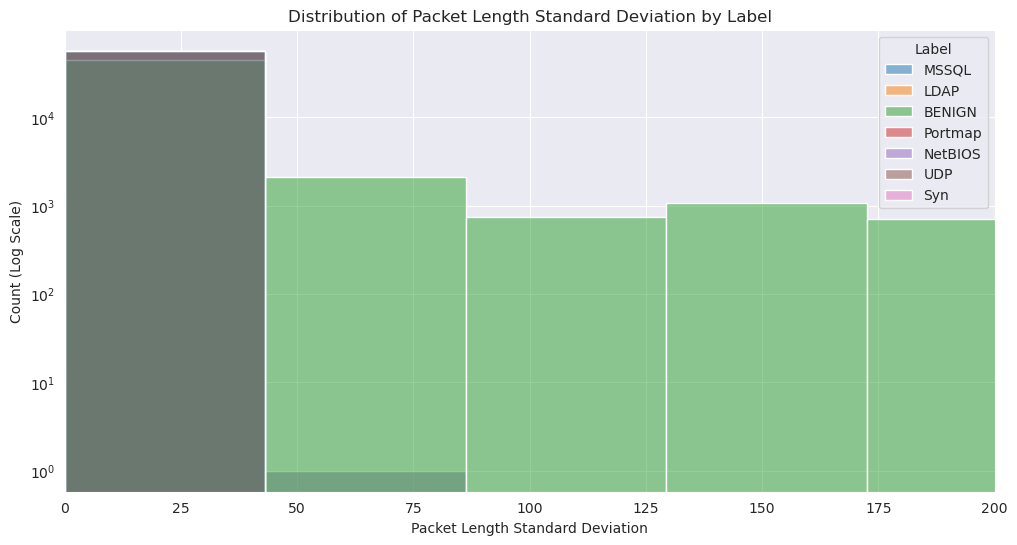

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with good size
plt.figure(figsize=(12, 6))

# Create histogram with log scale
sns.histplot(data=df,
            x='Packet_Length_Std',
            hue='Label',
            multiple="layer",
            alpha=0.5,
            bins=30)

plt.yscale('log')  # Set log scale for y-axis
plt.title('Distribution of Packet Length Standard Deviation by Label')
plt.xlabel('Packet Length Standard Deviation')
plt.ylabel('Count (Log Scale)')

# Optional: Set x-axis limit to focus on main distribution
plt.xlim(0, 200)  # Adjust these values based on your needs

plt.show()

In [19]:
from holoviews import dim
title = "MPG by Cylinders and Data Source, Colored by Cylinders"
boxwhisker = hv.BoxWhisker(df, 'Label', 'Packet_Length_Std', label=title)
boxwhisker.opts(show_legend=False, width=600, box_fill_color=dim('Label').str(), cmap='Set1')


:BoxWhisker   [Label]   (Packet_Length_Std)

In [56]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(12, 6))
numeric_columns = df.select_dtypes(include=np.number).columns
num_columns = len(numeric_columns)

# Set up the figure and axes
fig, axes = plt.subplots(num_columns, 1, figsize=(12, 6 * num_columns))
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Loop through each numerical column and create plots
for i, column in enumerate(numeric_columns):

    # Histogram (Left Subplot)
    sns.histplot(data=df, x=column, hue='Label',
                 bins=500)
    plt.yscale('log')  # Set log scale for y-axis
    # Optional: Set x-axis limit to focus on main distribution
    #plt.xlim(0, 500)  # Adjust these values based on your needs
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')



plt.show()

/home/brandon/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


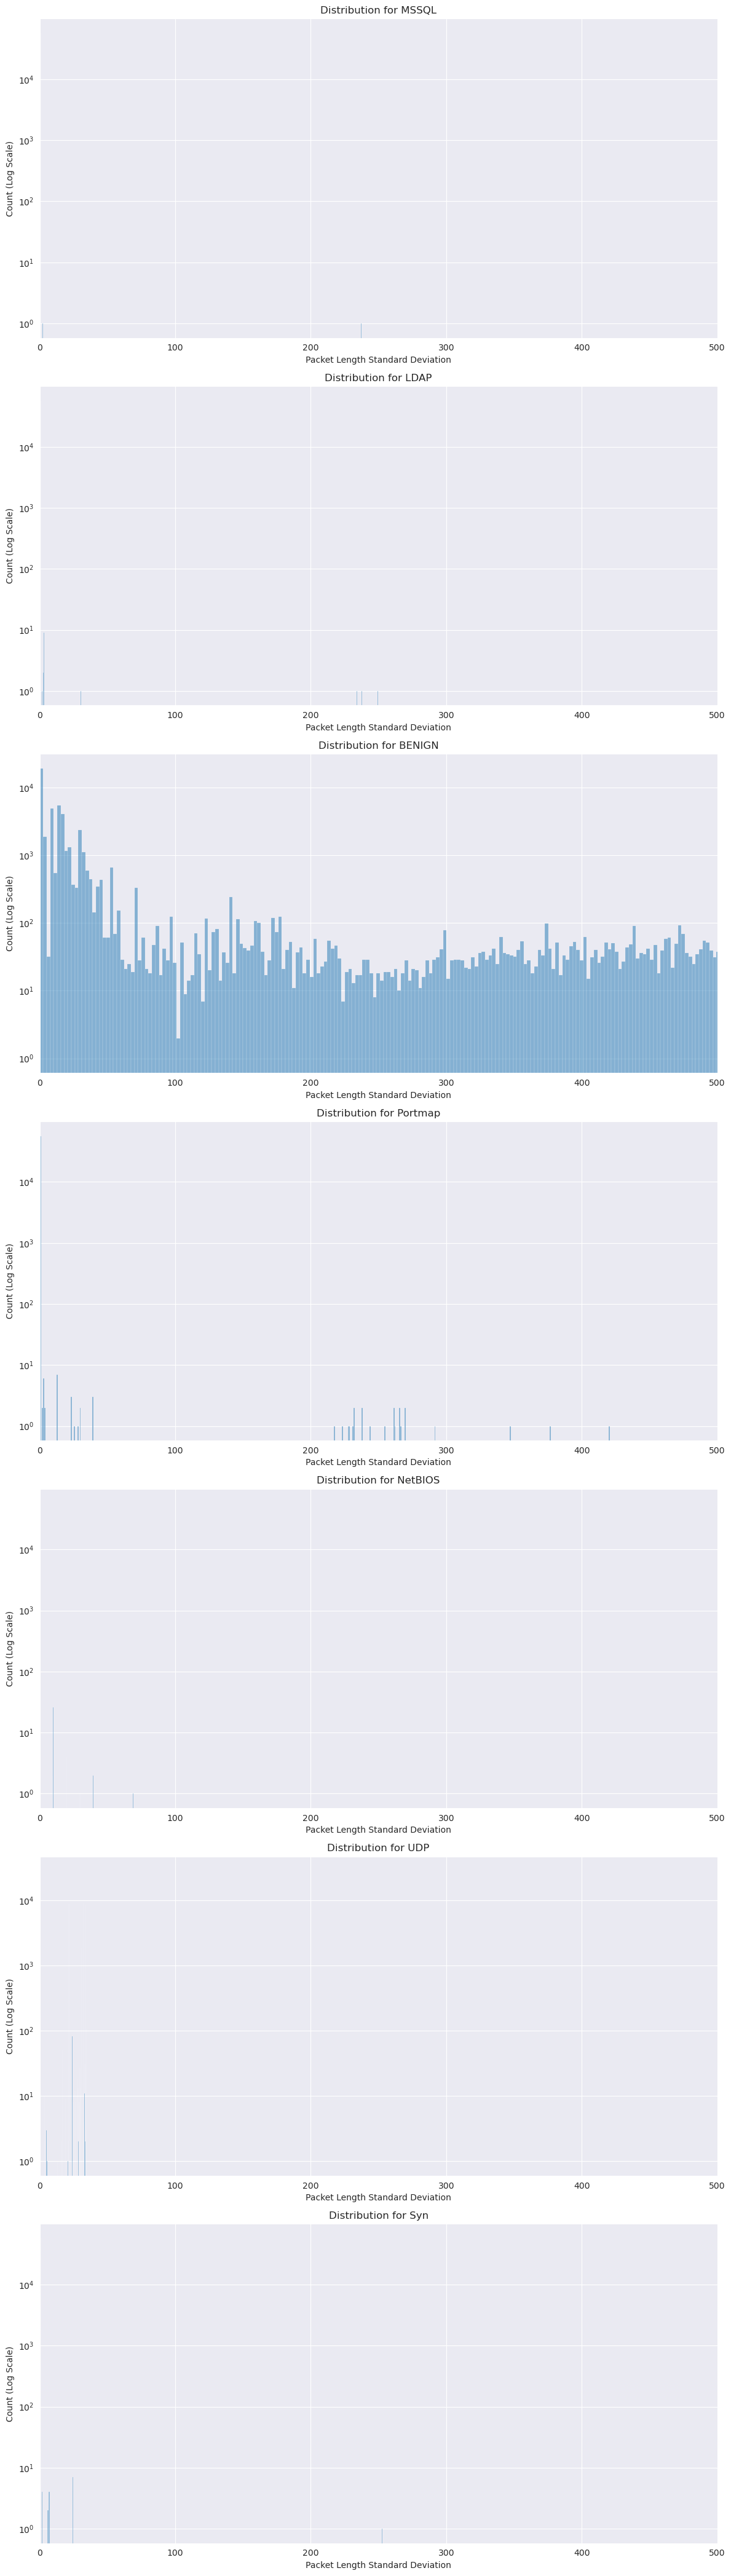

In [47]:
# Get unique labels
unique_labels = df['Label'].unique()

plt.figure(figsize=(12, 42))

for i, label in enumerate(unique_labels, 1):
    plt.subplot(7, 1, i)  # Adjust rows/columns based on number of labels

    # Create histogram for this label
    sns.histplot(data=df[df['Label'] == label],
                x='Packet_Length_Std',
                bins=500,
                alpha=0.5)

    plt.yscale('log')
    plt.xlim(0, 500)
    plt.title(f'Distribution for {label}')
    plt.xlabel('Packet Length Standard Deviation')
    plt.ylabel('Count (Log Scale)')

plt.tight_layout()
plt.show()

In [5]:

hist = hv_ds.hist(dimension='Packet_Length_Std', groupby='Label')

hist.opts(opts.Histogram(alpha=0.9, width=800, muted_fill_alpha=0.1))

AttributeError: 'NoneType' object has no attribute 'height'

:AdjointLayout
   :Dataset   [Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,CWE_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segm

In [3]:
from cuml.preprocessing import StandardScaler
from cuml.preprocessing import MinMaxScaler
import cupy
features = cudf_df.select_dtypes(include=np.number)
scaler = MinMaxScaler()
#scaled = scaler.fit(features)
x_scaled = scaler.fit_transform(features)
kmeans_model = KMeans(n_clusters=7)
cudf_df['clusters'] = kmeans_model.fit_predict(x_scaled)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
features = df.select_dtypes(include=np.number)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # X contains the selected numerical features
kmeans = KMeans(n_clusters=7, random_state=42)
df['clusters'] = kmeans.fit_predict(X_scaled)

In [5]:
df = cudf_df.to_pandas()

ValueError: Contour levels must be increasing

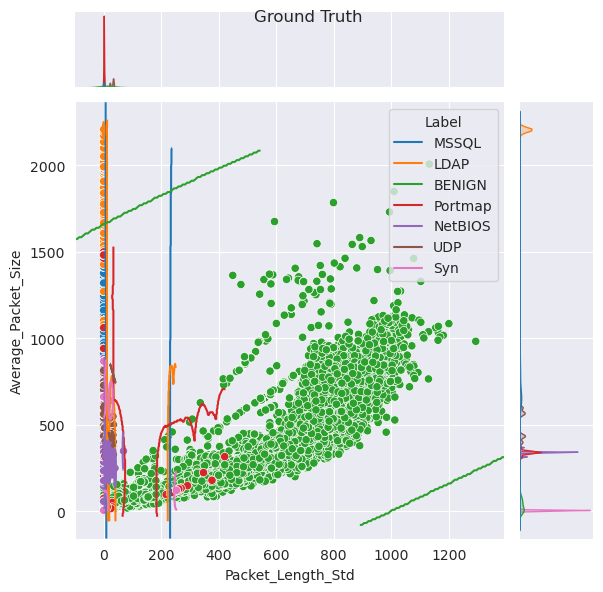

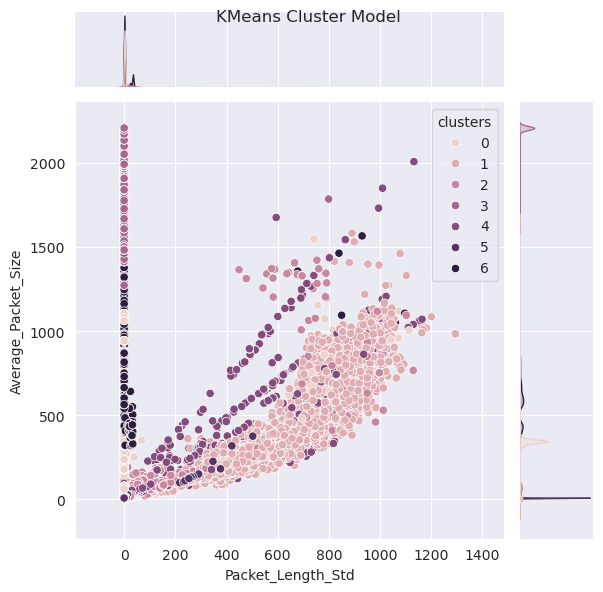

In [7]:
# Ground Truth Plot
figure_ground_truth = sns.jointplot(data=df, x="Packet_Length_Std", y="Average_Packet_Size", hue="Label")
figure_ground_truth.fig.suptitle("Ground Truth")
# Modify KDE parameters to ensure increasing contour levels
figure_ground_truth.plot_joint(sns.kdeplot, levels=np.linspace(0, 1, 7))

# Clusters Plot
figure_clusters = sns.jointplot(data=df, x="Packet_Length_Std", y="Average_Packet_Size", hue="clusters")
figure_clusters.fig.suptitle("KMeans Cluster Model")
figure_clusters.plot_joint(sns.kdeplot, levels=np.linspace(0, 1, 7))


In [ ]:
labels = df['Label']
clusters = df['clusters']

In [10]:
from sklearn.metrics import silhouette_score
score = silhouette_score(clusters, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.5820168266852634


In [11]:
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(clusters, labels)
print("Davies-Bouldin Index:", db_score)

Davies-Bouldin Index: 1.274431558207198


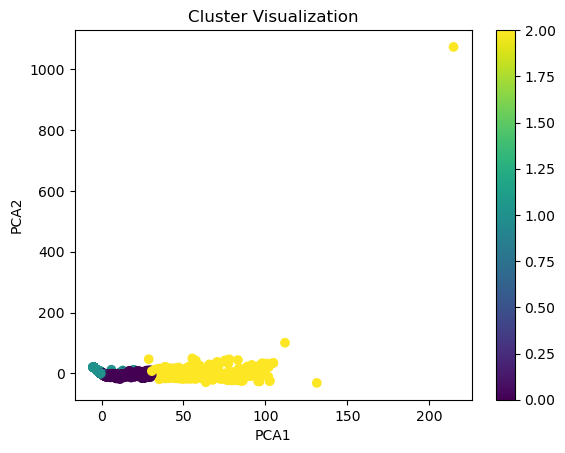

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.show()


In [235]:
portmap_df = df[df['Label'] == 'Portmap']
benign_df = df[df['Label'] == 'BENIGN']

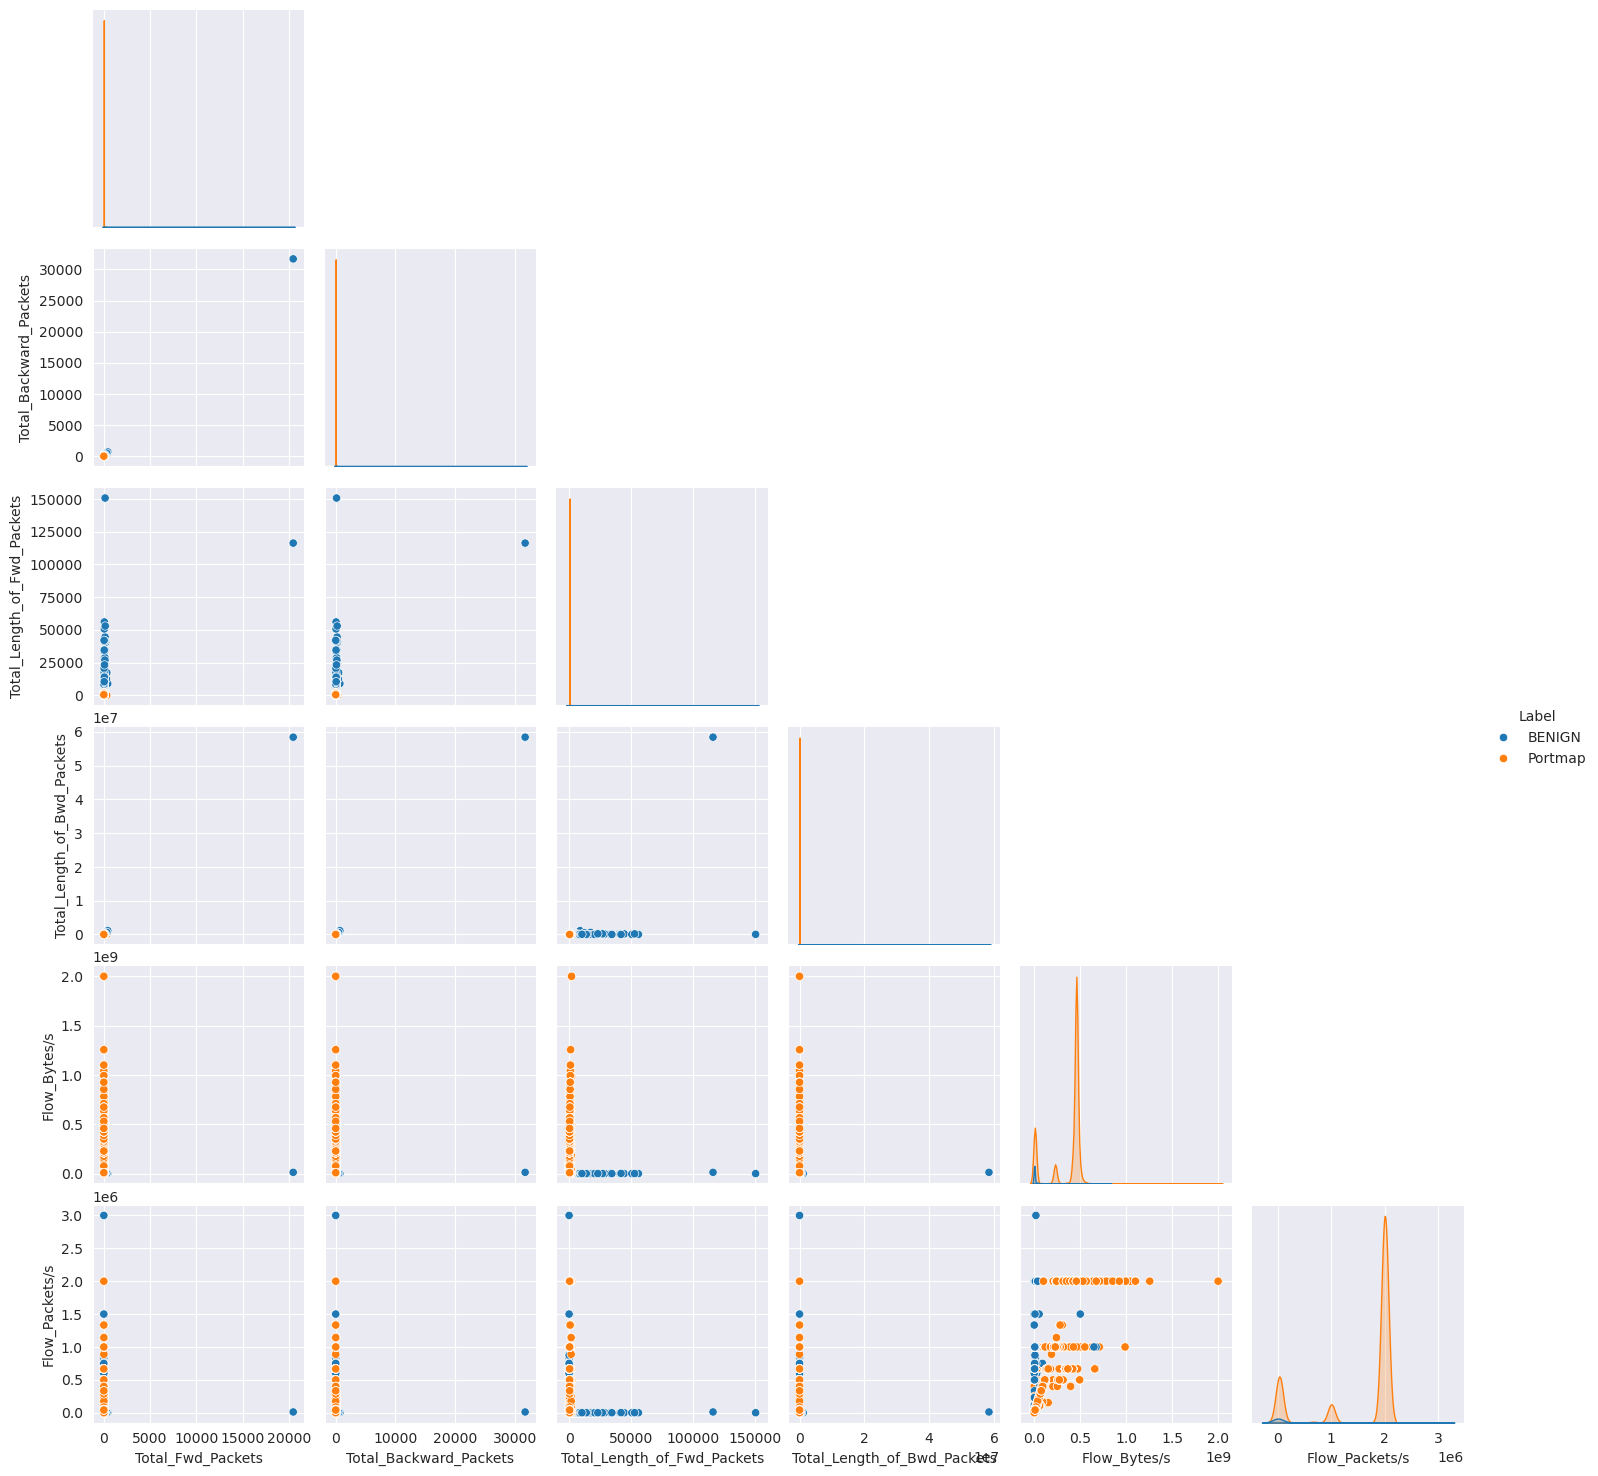

In [16]:
traffic_volume = ["Total_Fwd_Packets", "Total_Backward_Packets",
    "Total_Length_of_Fwd_Packets", "Total_Length_of_Bwd_Packets",
    "Flow_Bytes/s", "Flow_Packets/s", "Label"]

sns.pairplot(df[traffic_volume], hue = 'Label', corner=True)

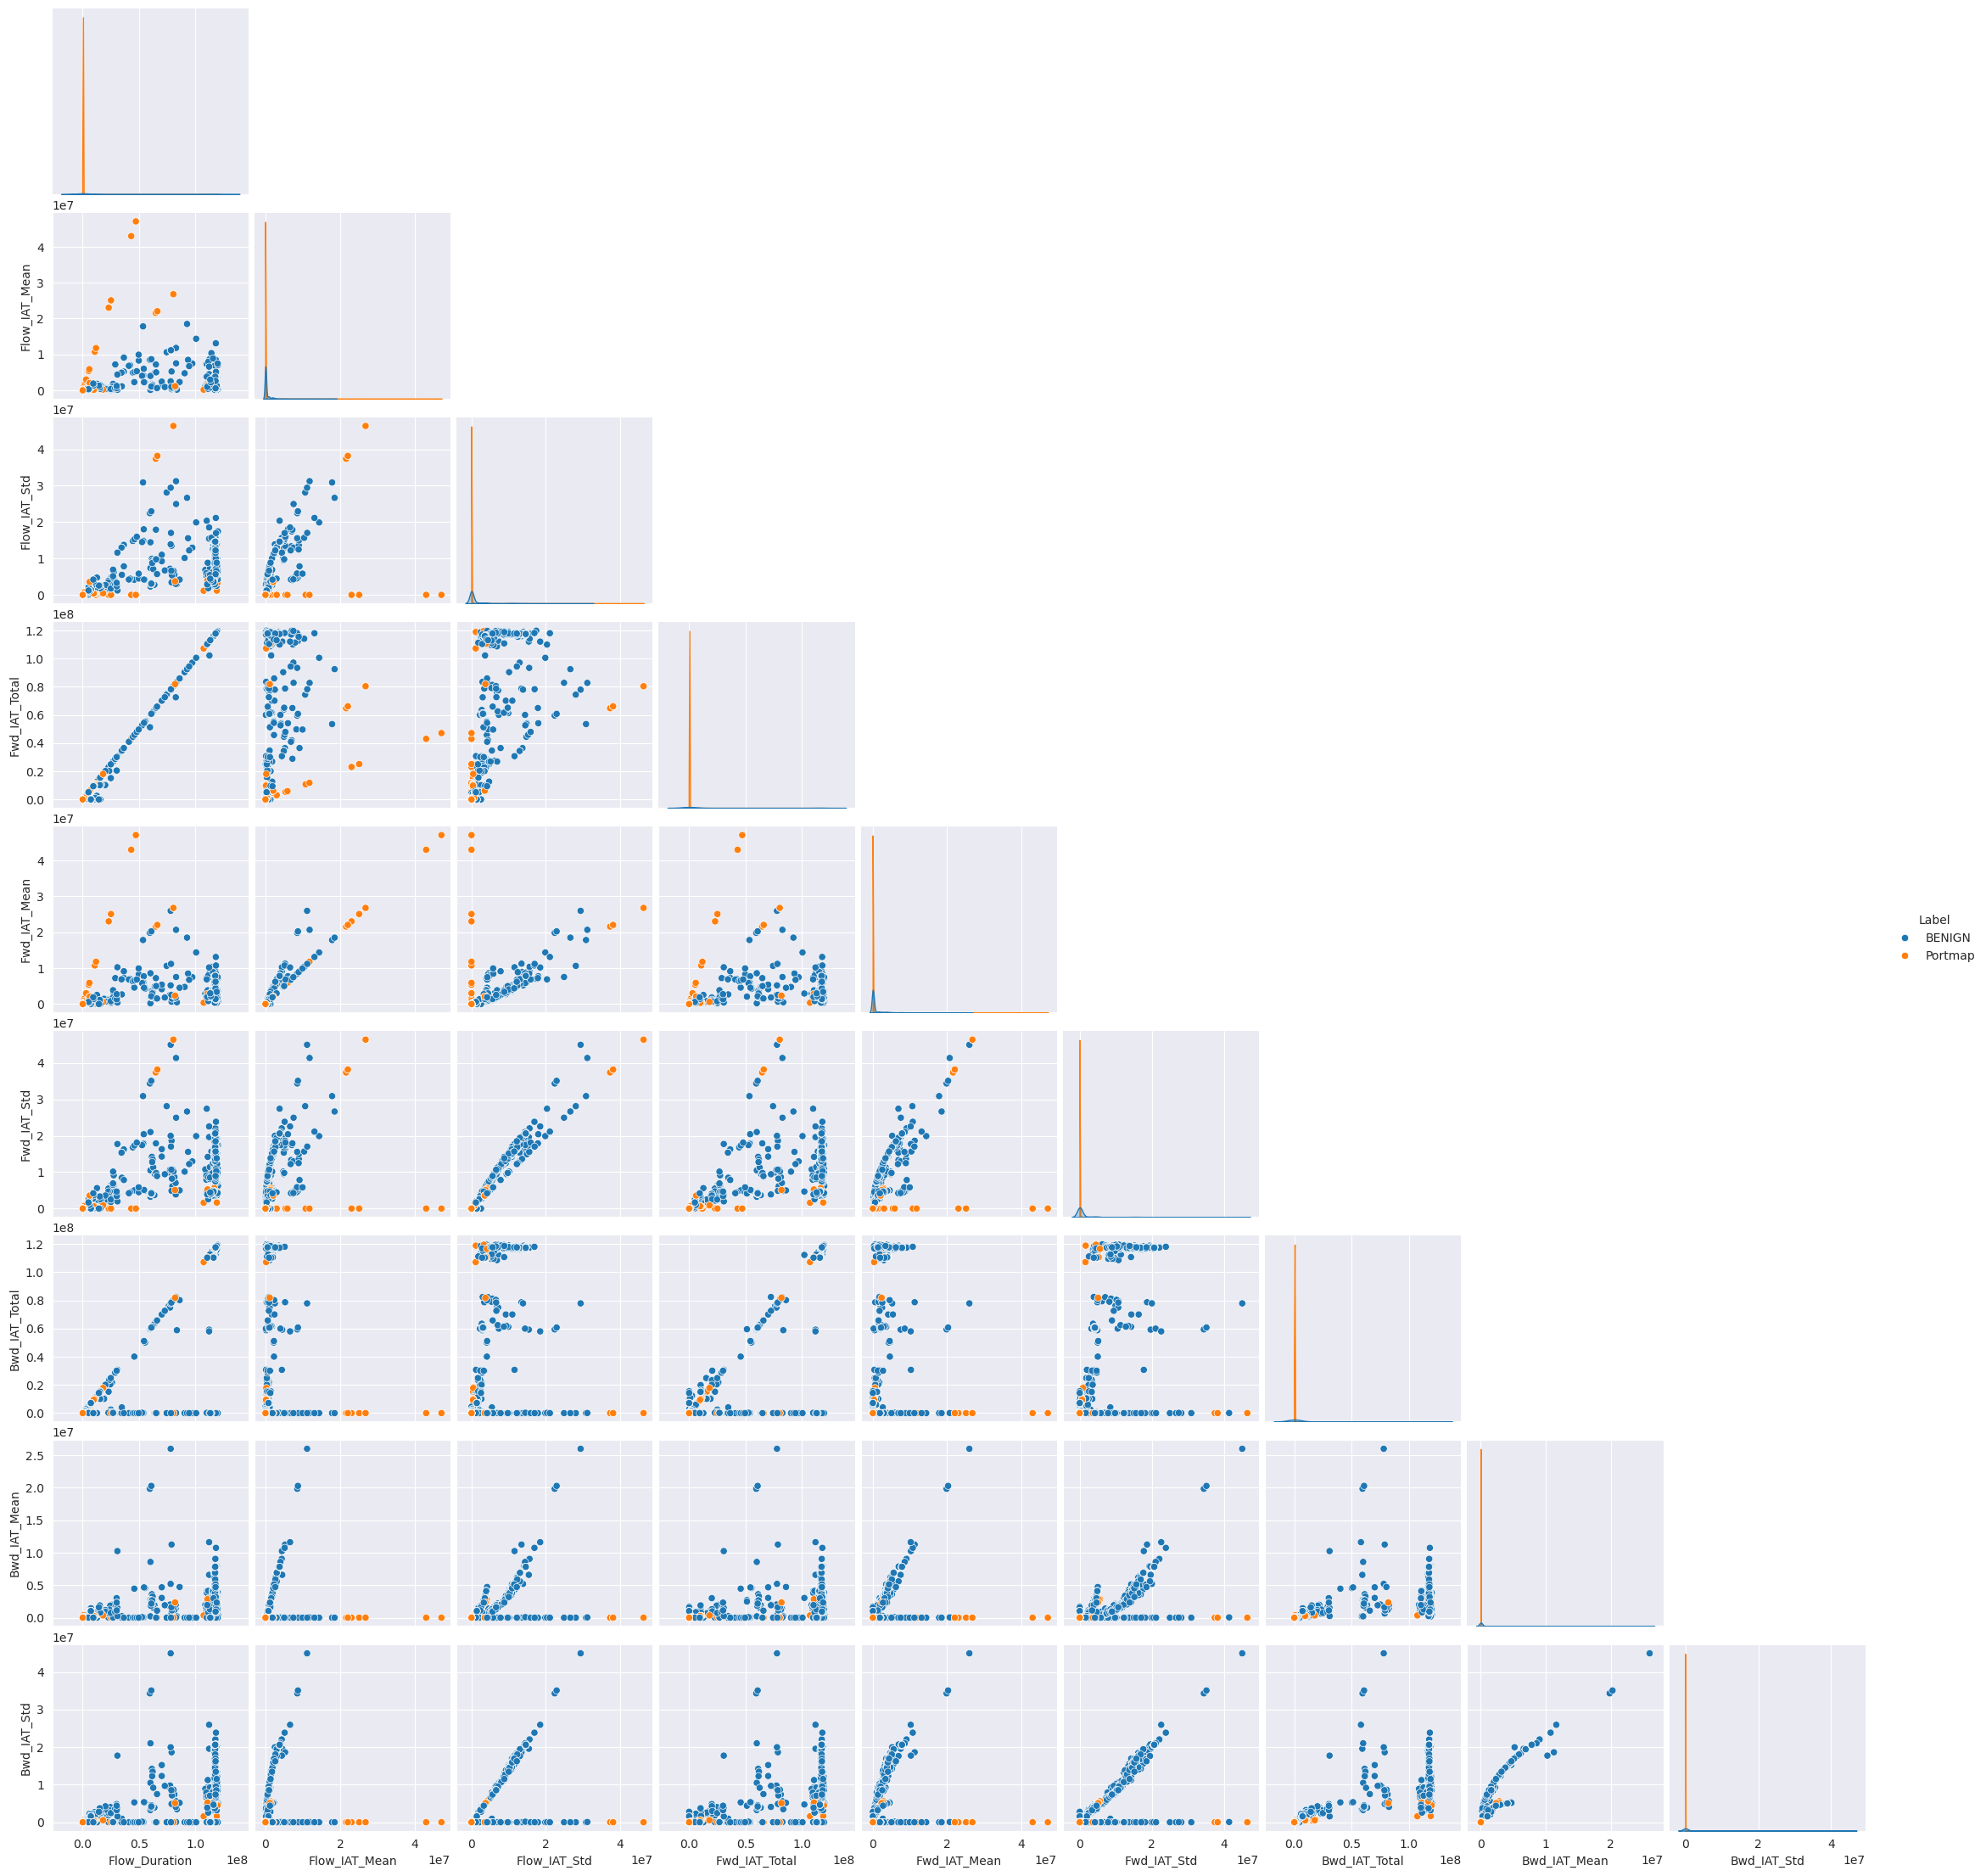

In [18]:

timing_metrics = ["Flow_Duration",
    "Flow_IAT_Mean", "Flow_IAT_Std", "Fwd_IAT_Total",
    "Fwd_IAT_Mean", "Fwd_IAT_Std", "Bwd_IAT_Total",
    "Bwd_IAT_Mean", "Bwd_IAT_Std", "Label"]

sns.pairplot(df[timing_metrics], hue = 'Label', corner=True)

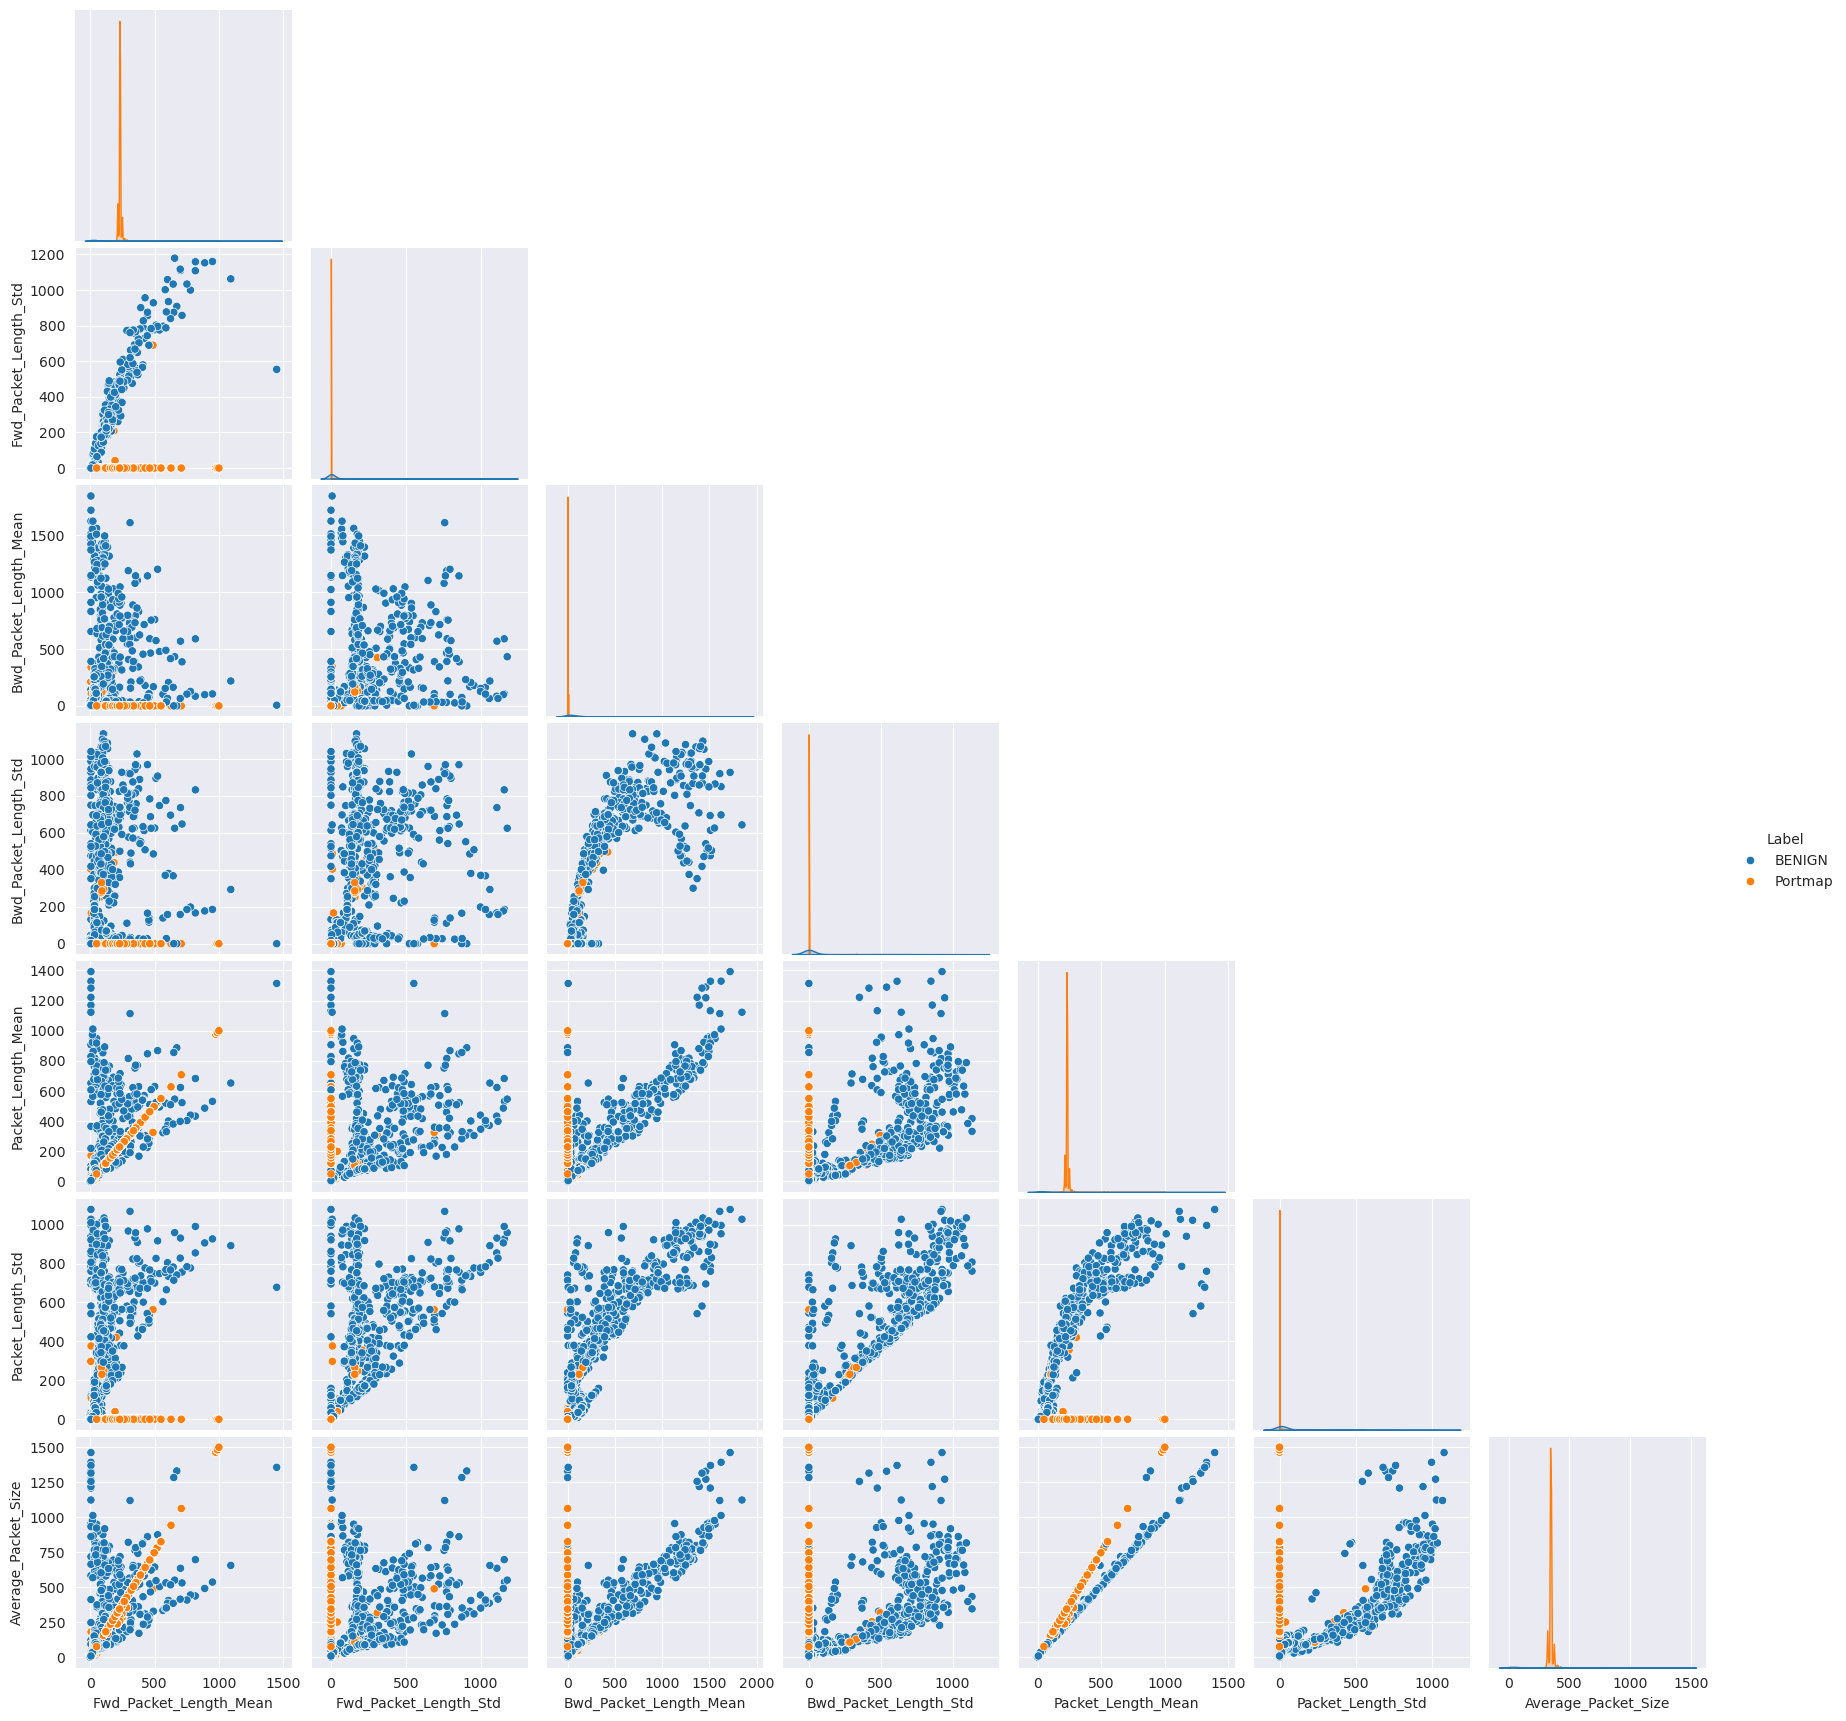

In [19]:


packet_characteristics = ["Fwd_Packet_Length_Mean",
    "Fwd_Packet_Length_Std", "Bwd_Packet_Length_Mean",
    "Bwd_Packet_Length_Std", "Packet_Length_Mean",
    "Packet_Length_Std", "Average_Packet_Size", 'Label']

sns.pairplot(df[packet_characteristics], hue = 'Label', corner=True)

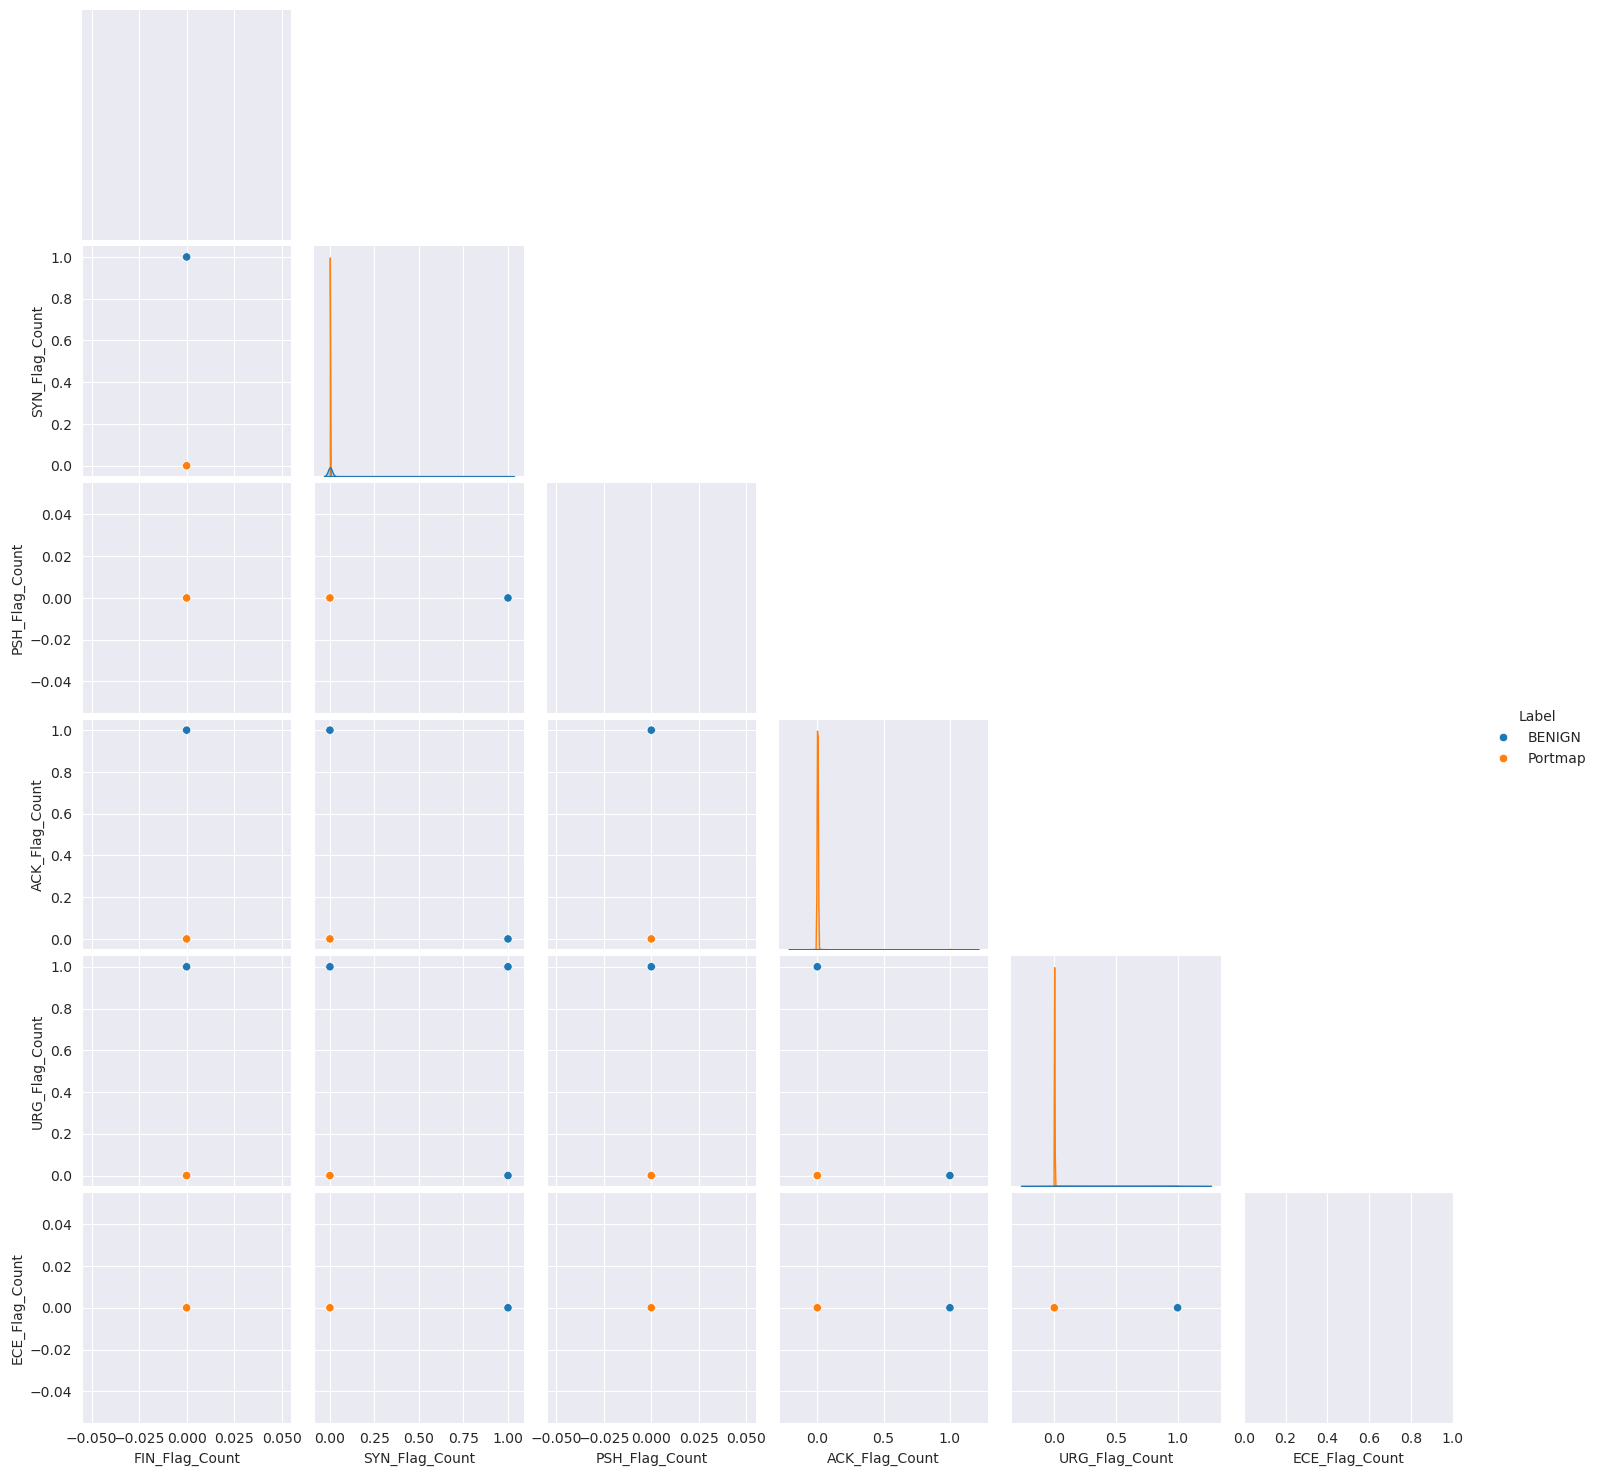

In [20]:


protocol_flags = ["FIN_Flag_Count", "SYN_Flag_Count", "PSH_Flag_Count",
    "ACK_Flag_Count", "URG_Flag_Count", "ECE_Flag_Count", "Label"]

sns.pairplot(df[protocol_flags], hue = 'Label', corner=True)

In [1]:


misc = ["Active_Mean", "Idle_Mean", "Down/Up_Ratio", "Label"]

sns.pairplot(df[misc], hue = 'Label', corner=True)

NameError: name 'sns' is not defined

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 4734 entries, 0 to 136704
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total_Fwd_Packets            4734 non-null   int64  
 1   Total_Backward_Packets       4734 non-null   int64  
 2   Total_Length_of_Fwd_Packets  4734 non-null   float64
 3   Total_Length_of_Bwd_Packets  4734 non-null   float64
 4   Flow_Bytes/s                 4734 non-null   float64
 5   Flow_Packets/s               4734 non-null   float64
 6   Flow_Duration                4734 non-null   int64  
 7   Flow_IAT_Mean                4734 non-null   float64
 8   Flow_IAT_Std                 4734 non-null   float64
 9   Fwd_IAT_Total                4734 non-null   float64
 10  Fwd_IAT_Mean                 4734 non-null   float64
 11  Fwd_IAT_Std                  4734 non-null   float64
 12  Bwd_IAT_Total                4734 non-null   float64
 13  Bwd

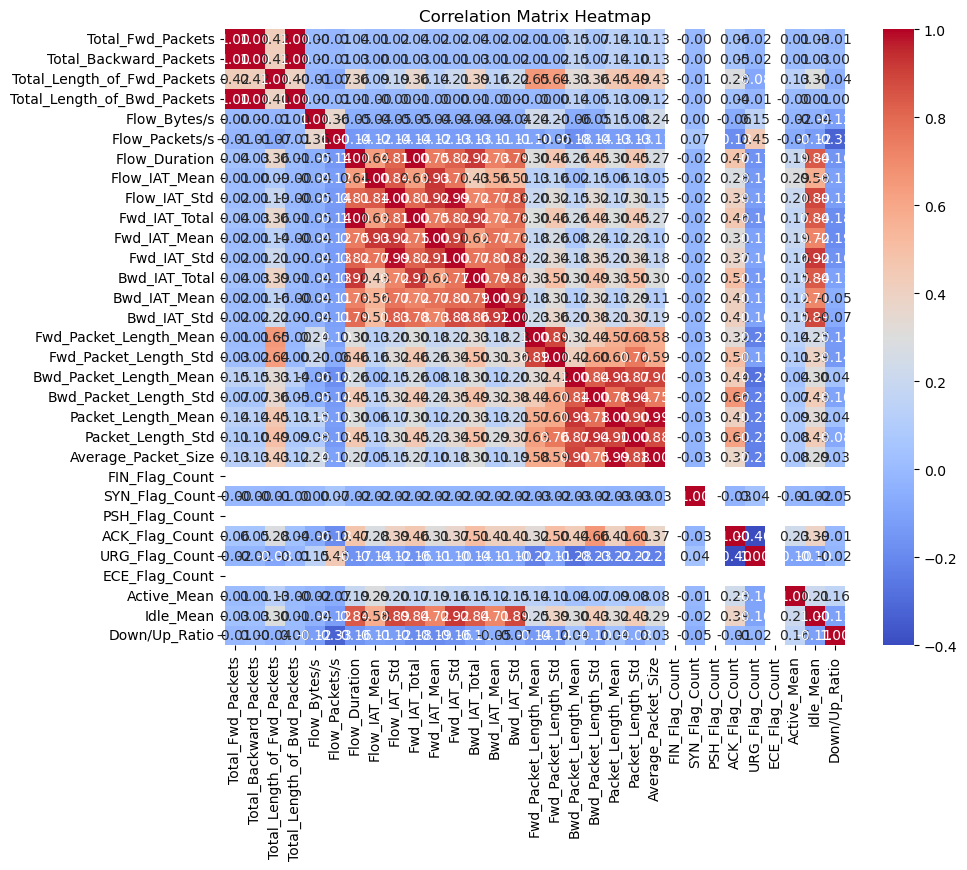

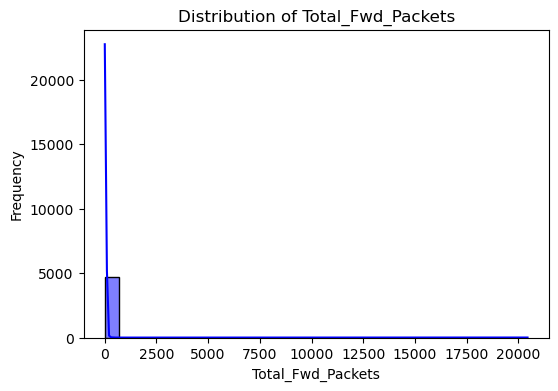

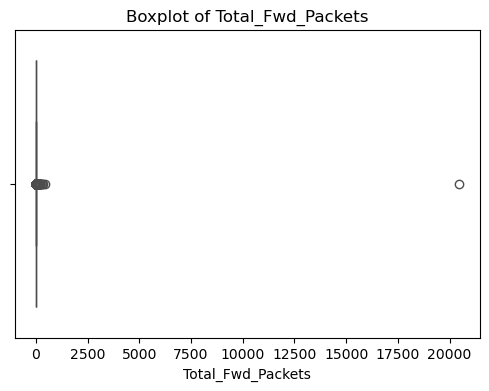

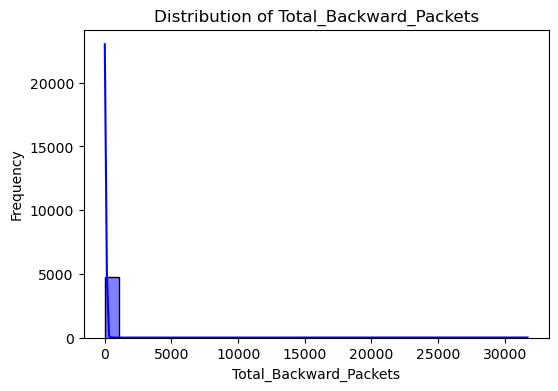

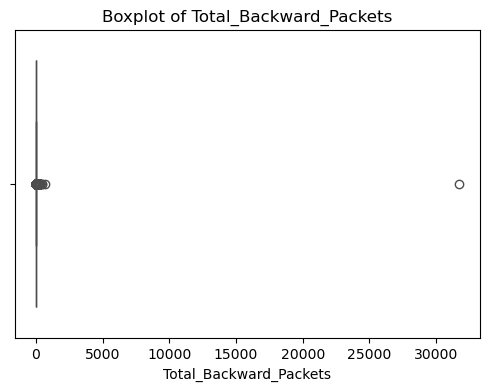

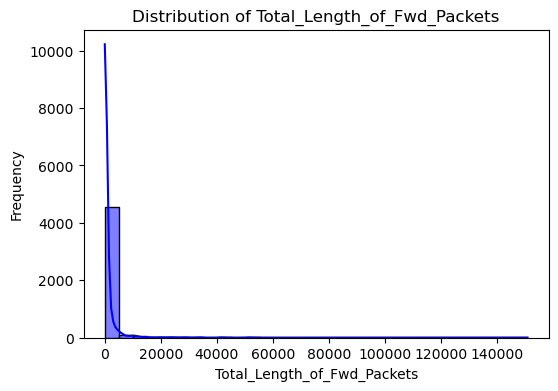

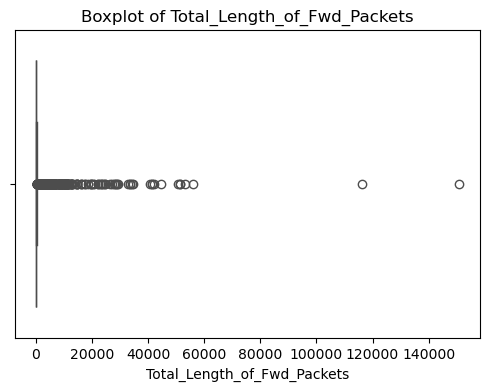

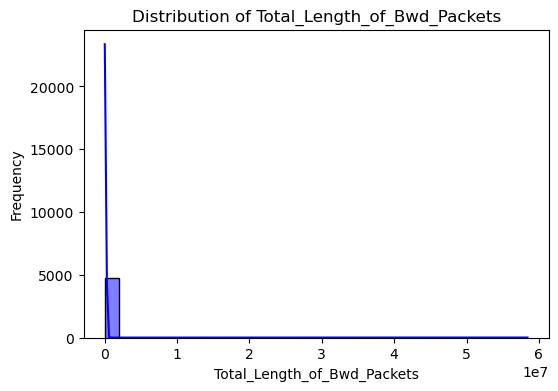

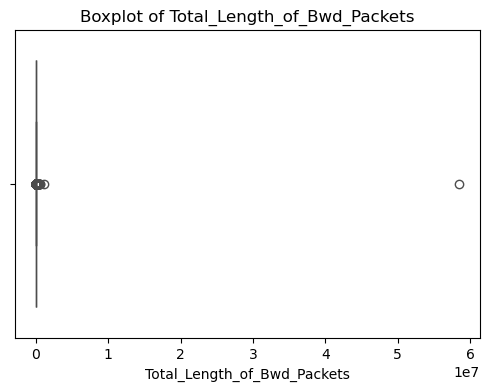

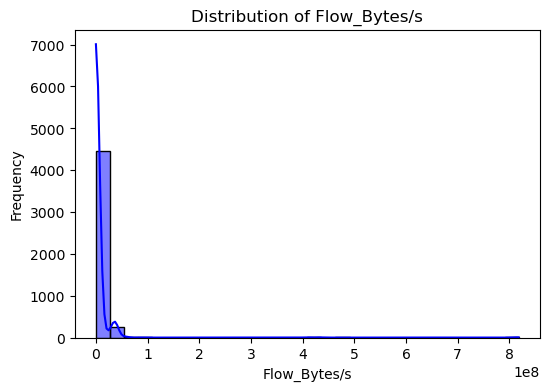

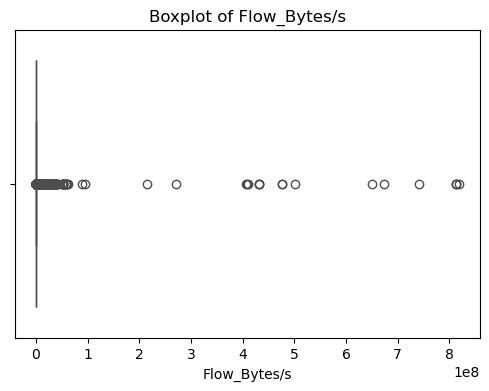

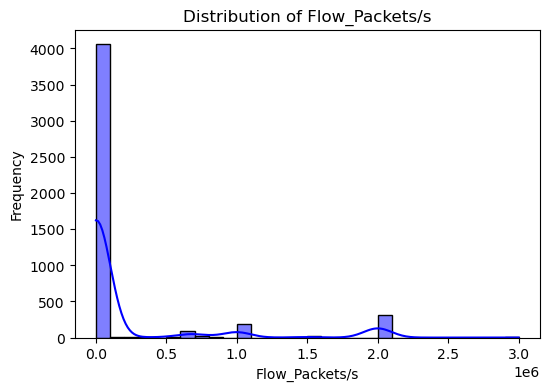

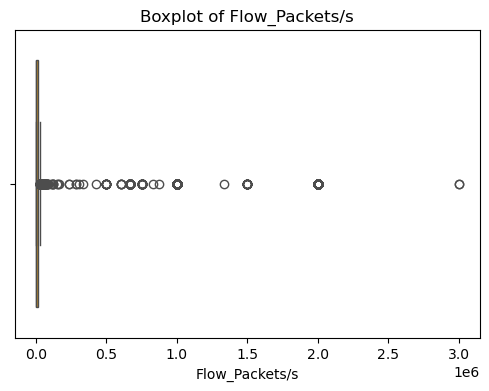

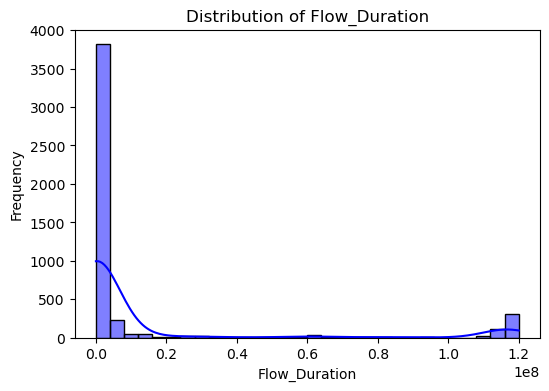

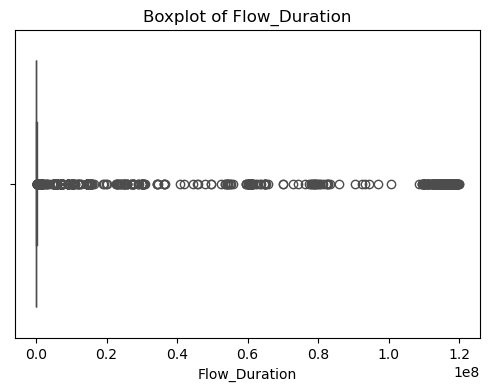

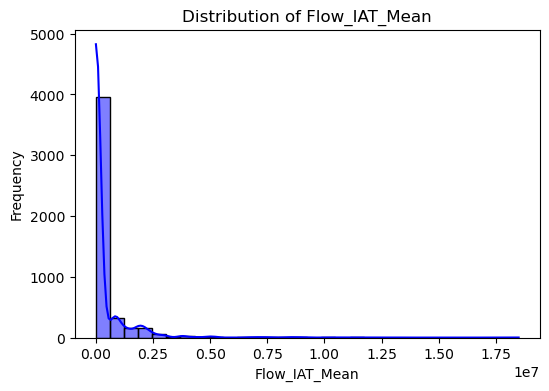

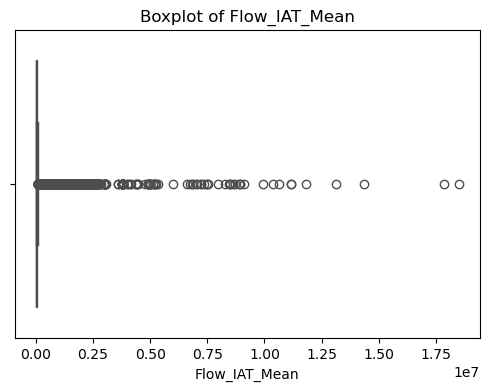

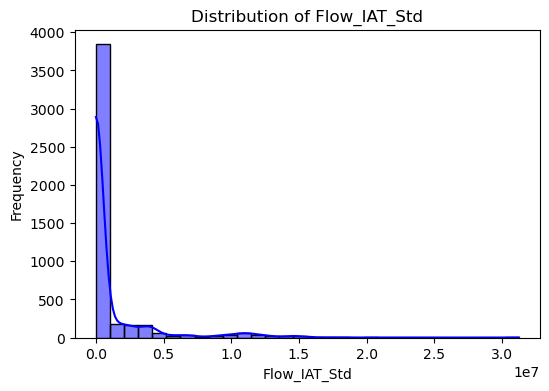

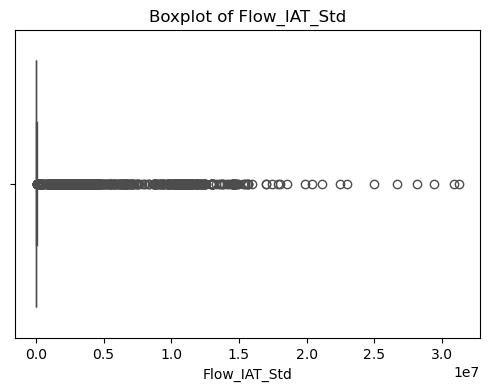

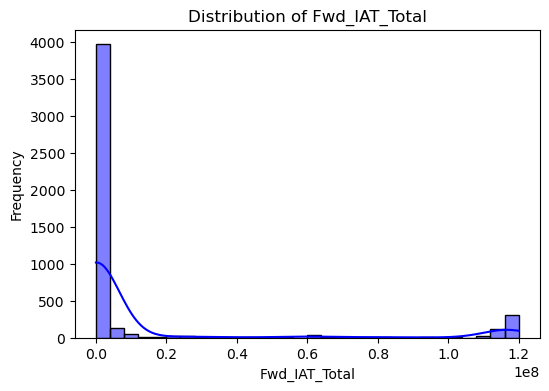

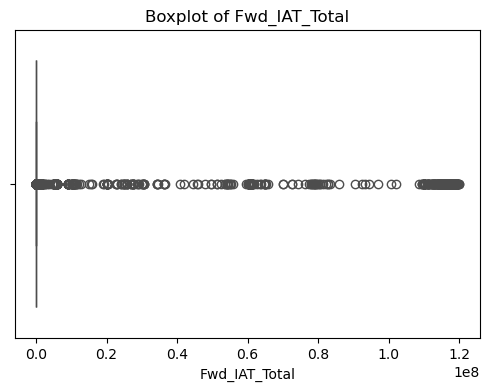

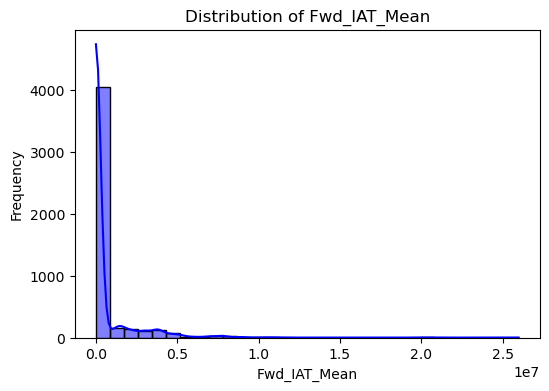

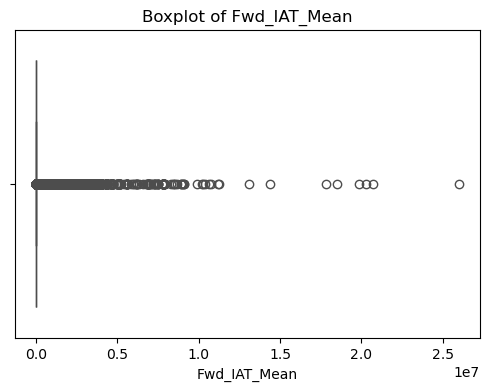

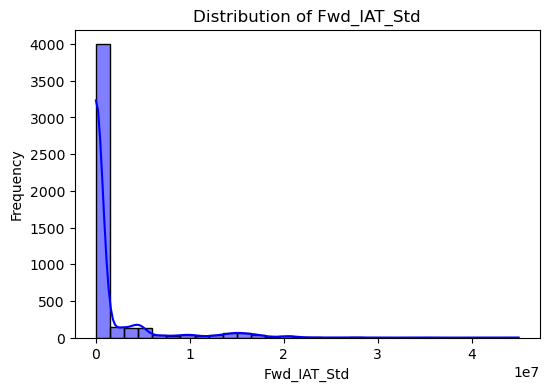

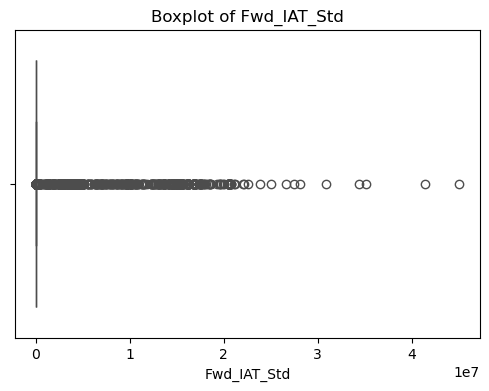

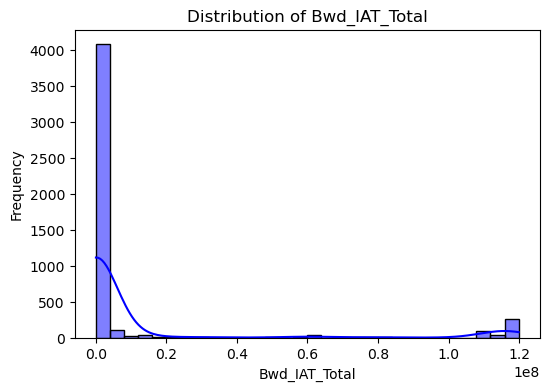

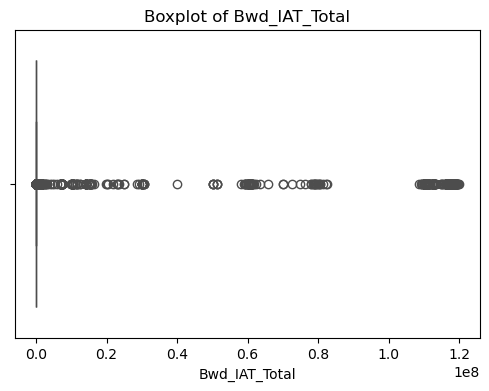

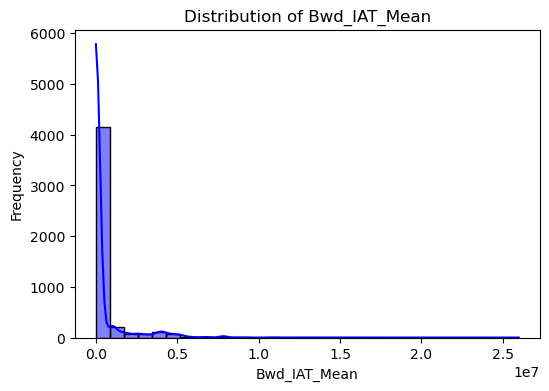

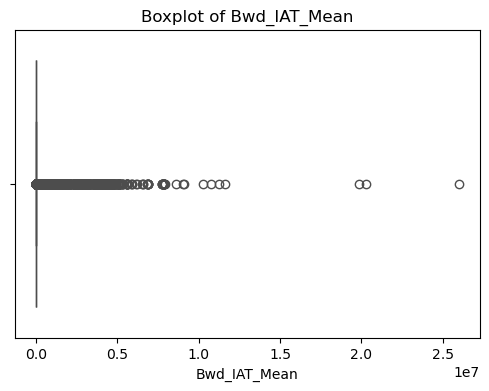

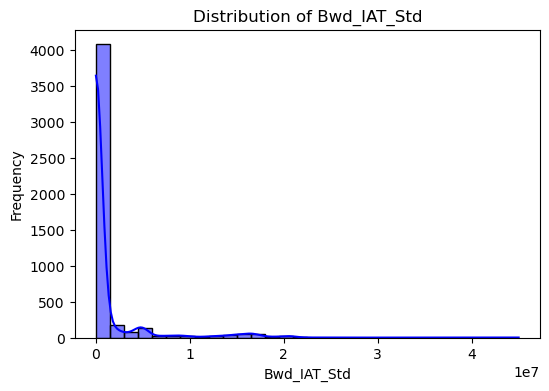

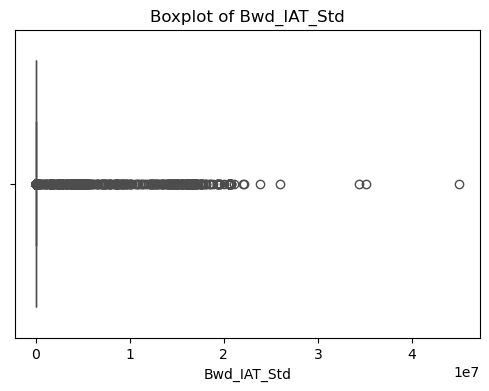

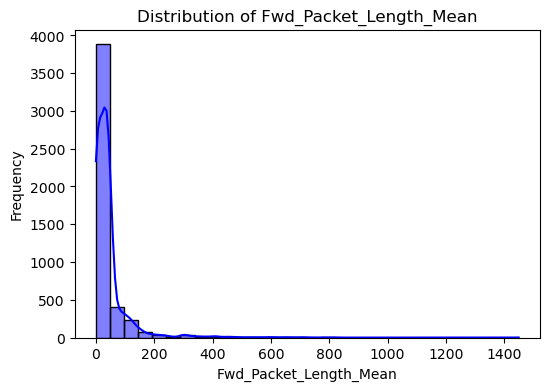

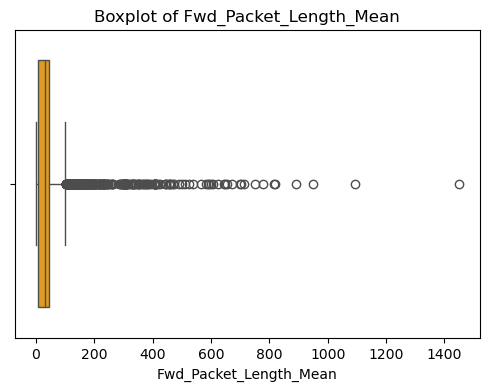

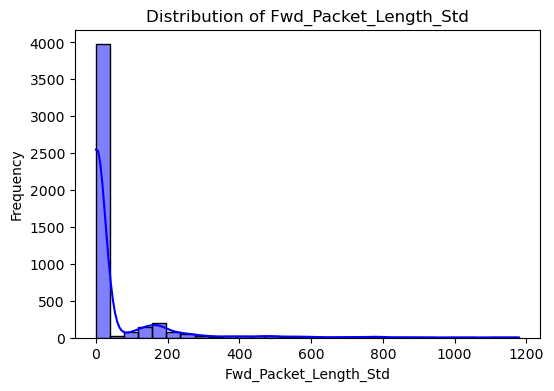

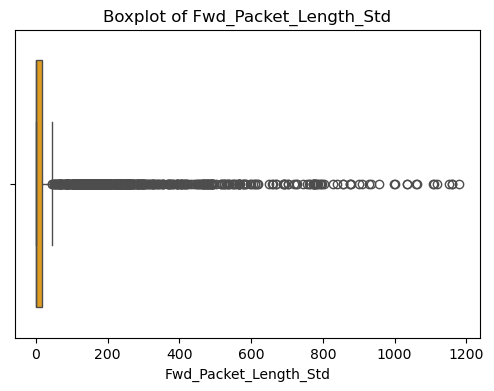

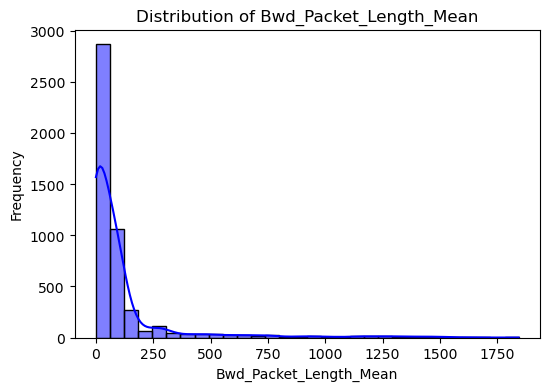

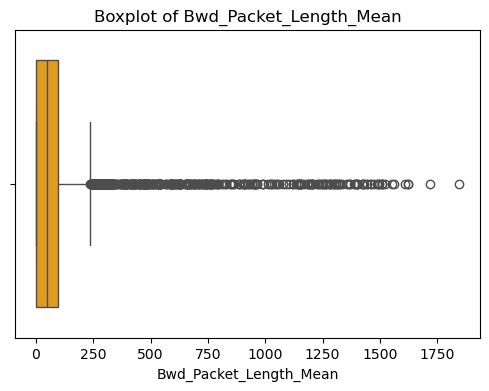

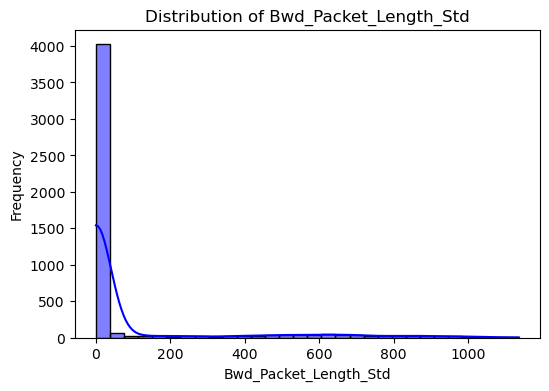

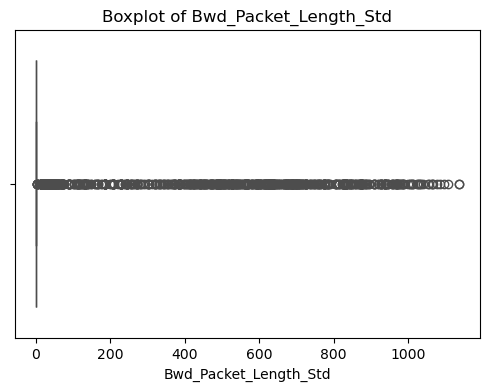

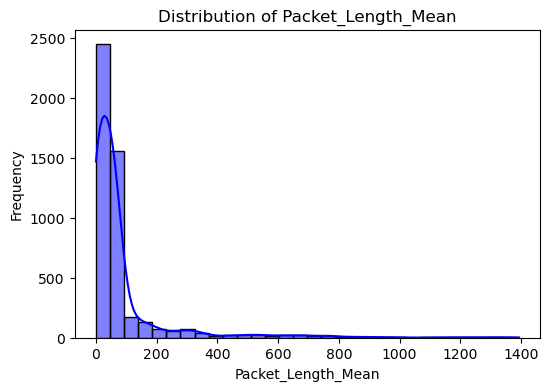

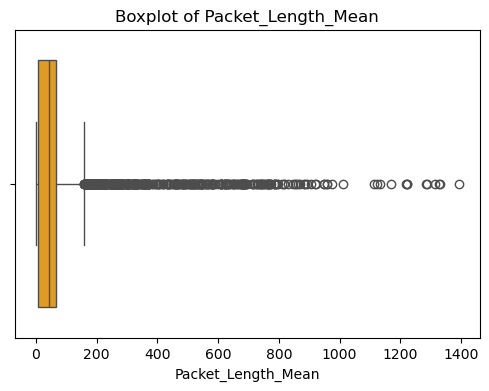

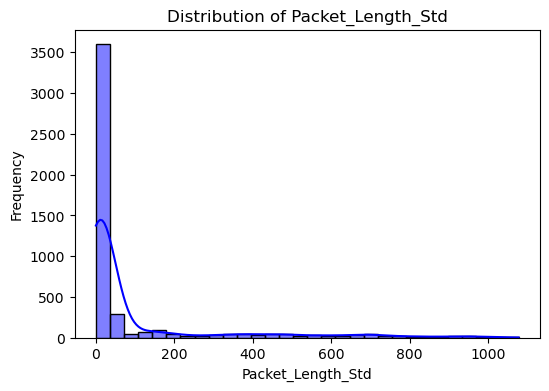

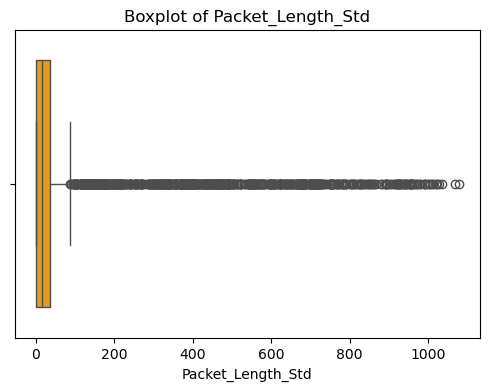

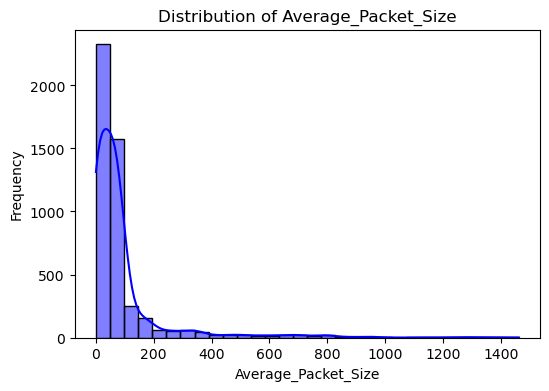

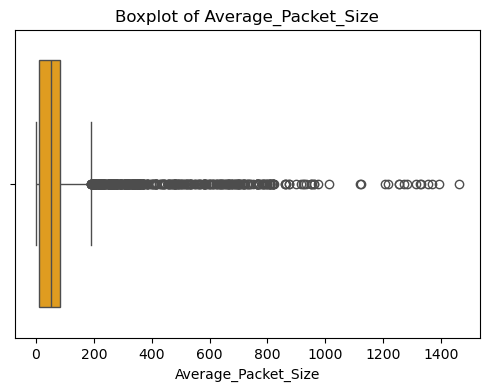

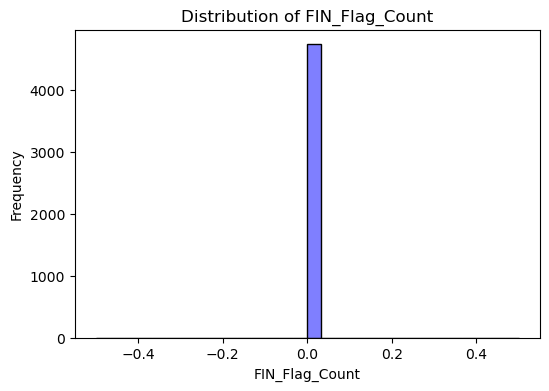

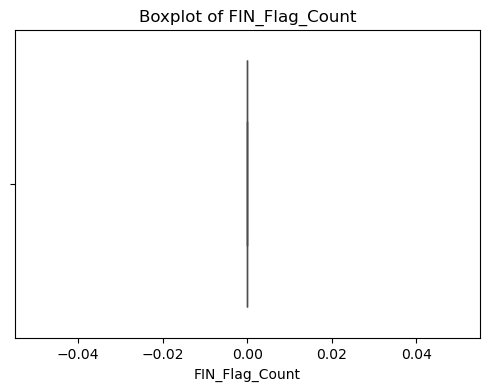

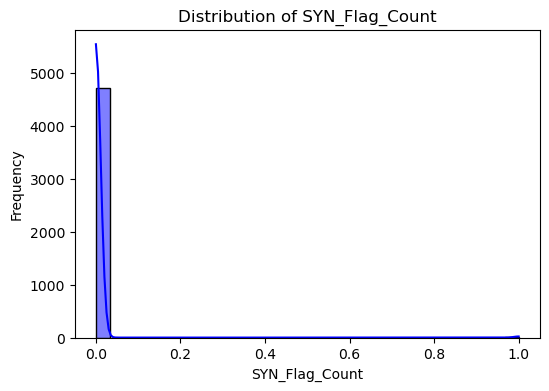

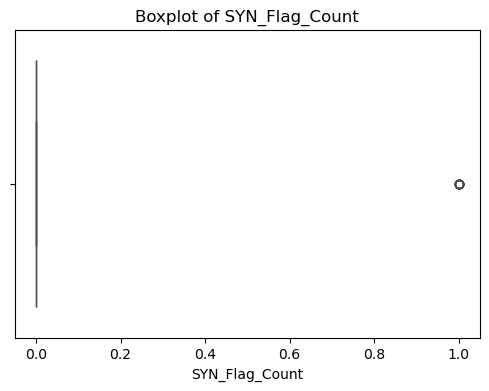

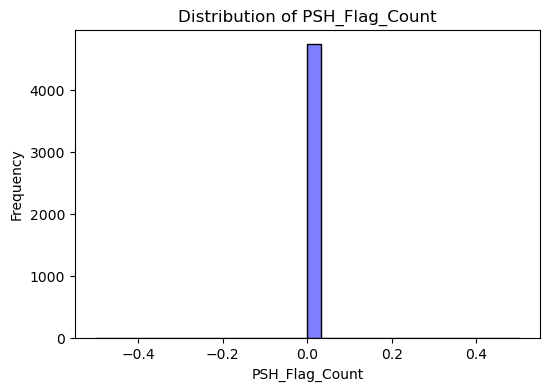

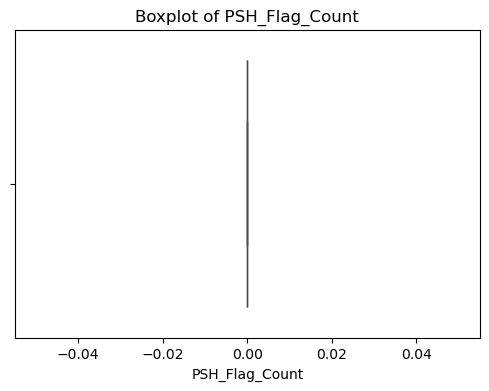

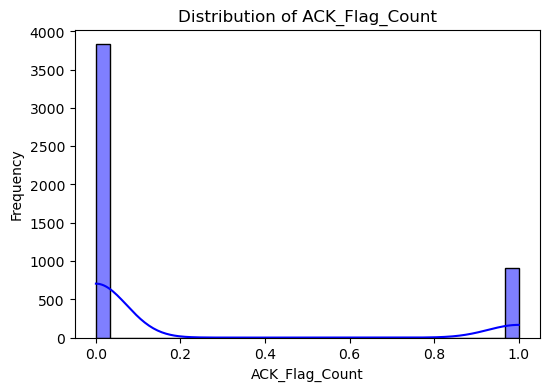

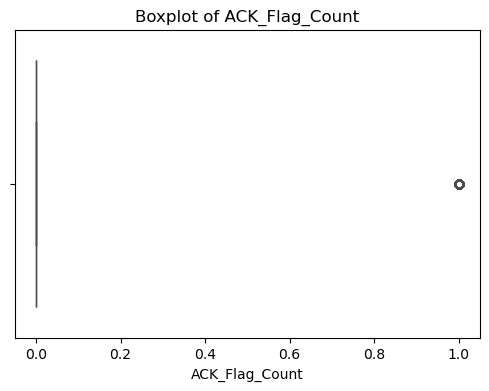

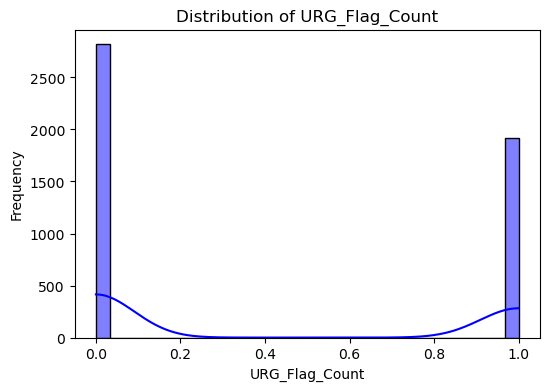

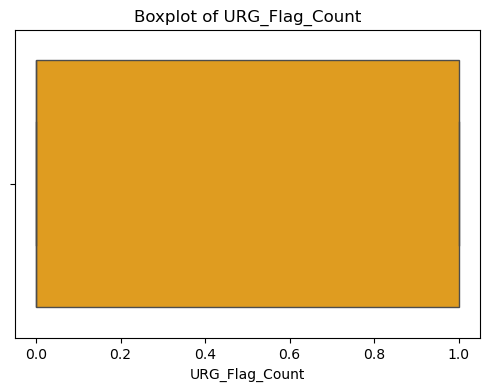

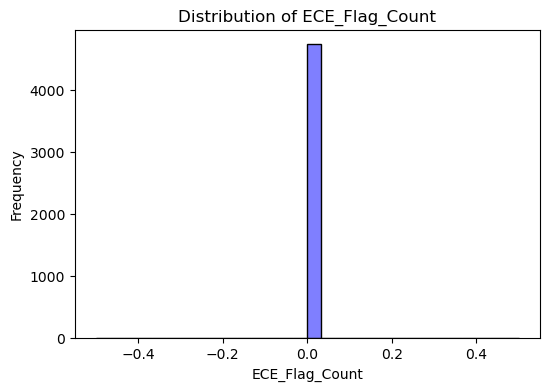

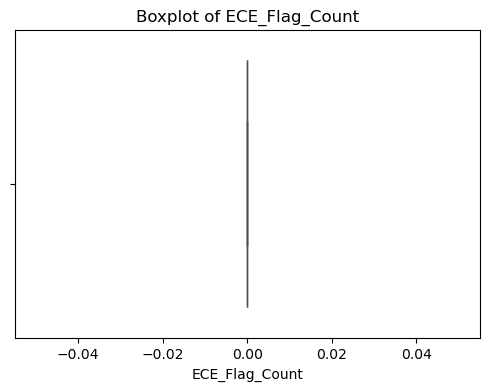

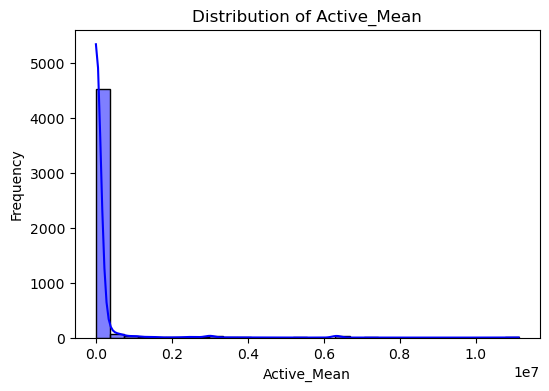

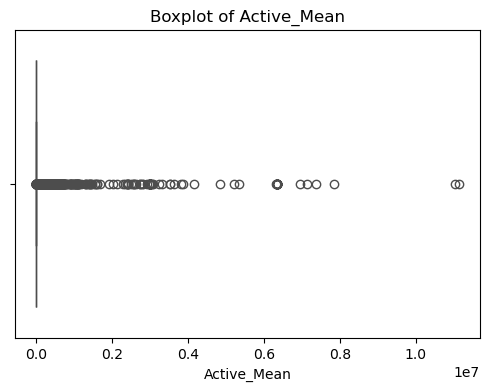

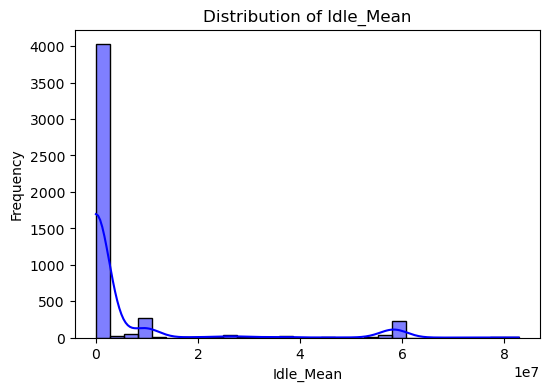

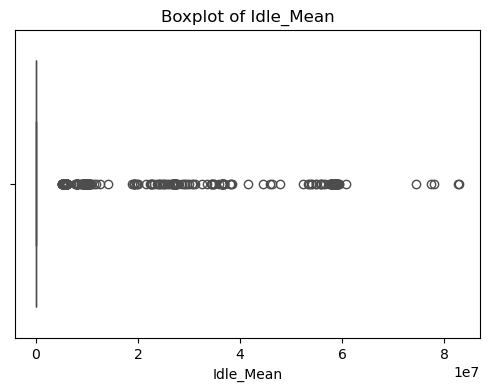

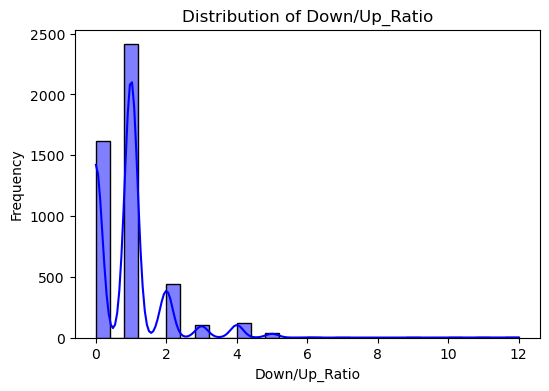

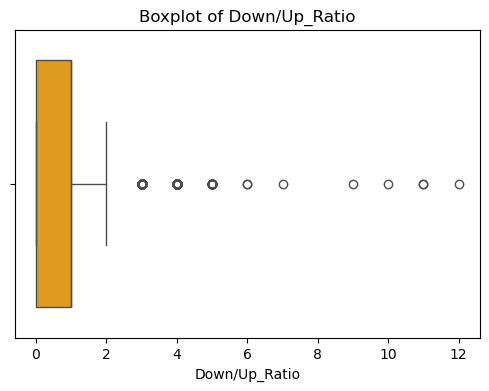

In [236]:
relevant_columns = [
    "Total_Fwd_Packets", "Total_Backward_Packets",
    "Total_Length_of_Fwd_Packets", "Total_Length_of_Bwd_Packets",
    "Flow_Bytes/s", "Flow_Packets/s", "Flow_Duration",
    "Flow_IAT_Mean", "Flow_IAT_Std", "Fwd_IAT_Total",
    "Fwd_IAT_Mean", "Fwd_IAT_Std", "Bwd_IAT_Total",
    "Bwd_IAT_Mean", "Bwd_IAT_Std", "Fwd_Packet_Length_Mean",
    "Fwd_Packet_Length_Std", "Bwd_Packet_Length_Mean",
    "Bwd_Packet_Length_Std", "Packet_Length_Mean",
    "Packet_Length_Std", "Average_Packet_Size",
    "FIN_Flag_Count", "SYN_Flag_Count", "PSH_Flag_Count",
    "ACK_Flag_Count", "URG_Flag_Count", "ECE_Flag_Count",
    "Active_Mean", "Idle_Mean", "Down/Up_Ratio"
]
filtered_df = benign_df[relevant_columns]


da.descriptive_analytics(filtered_df)
da.visualize_data(filtered_df)